In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.distributions import Normal

from models.regression import BayesianRegressor


In [2]:
# Regression Target
def experiment(x, eps):
    return x + 0.3 * torch.sin(2 * torch.pi * (x + eps)) + 0.3 * torch.sin(4 * torch.pi * (x + eps)) + eps
    # return -x**4 + 3*x**2 + 1


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Creating Training Data

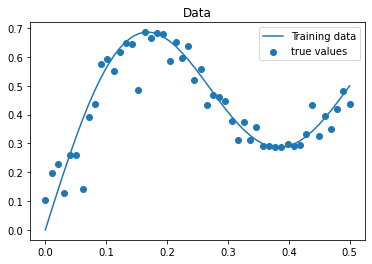

In [4]:
# toy dataset we can start with
train_samples = 50
x_train = torch.linspace(0, 0.5, train_samples).reshape(-1, 1)
eps = Normal(0, 0.02).sample(x_train.size())
y_train = experiment(x_train, eps)
y_train_true = experiment(x_train, 0)

plt.plot(x_train.numpy(), y_train_true.detach().numpy(), label='Training data')
plt.scatter(x_train, y_train, label='true values')
plt.title('Data')
plt.legend()
plt.show()


Defining model and training

In [5]:
model = BayesianRegressor(hidden_dim=128, var_gauss=0.05, mixture_prior=False).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
elbo_samples = 6
epochs = 2000

x_train = x_train.to(device)
y_train = y_train.to(device)

for epoch in range(epochs):  # loop over the dataset multiple times
    optimizer.zero_grad()
    # forward + backward + optimize
    loss = model.energy_loss(x_train, y_train, elbo_samples)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print('epoch: {}/{}'.format(epoch + 1, epochs))
        print('Loss:', loss.item())
print('Finished Training')

epoch: 1/2000
Loss: 3697.08251953125
epoch: 101/2000
Loss: 2818.840576171875
epoch: 201/2000
Loss: 2489.460205078125
epoch: 301/2000
Loss: 2191.609375
epoch: 401/2000
Loss: 1998.3878173828125
epoch: 501/2000
Loss: 1830.6834716796875
epoch: 601/2000
Loss: 1841.316650390625
epoch: 701/2000
Loss: 1696.9437255859375
epoch: 801/2000
Loss: 1748.904541015625
epoch: 901/2000
Loss: 1613.8135986328125
epoch: 1001/2000
Loss: 1569.0657958984375
epoch: 1101/2000
Loss: 1516.2412109375
epoch: 1201/2000
Loss: 1484.7054443359375
epoch: 1301/2000
Loss: 1477.28369140625
epoch: 1401/2000
Loss: 1441.76708984375
epoch: 1501/2000
Loss: 1475.1446533203125
epoch: 1601/2000
Loss: 1386.956787109375
epoch: 1701/2000
Loss: 1454.9180908203125
epoch: 1801/2000
Loss: 1706.71240234375
epoch: 1901/2000
Loss: 1783.27978515625
Finished Training


Prediction

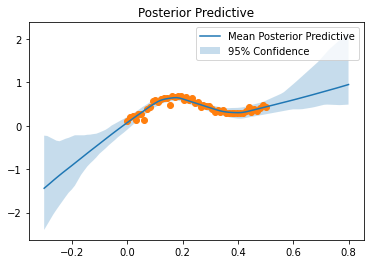

In [9]:
# samples is the number of "predictions" we make for 1 x-value.
test_samples = 100
exp_samples = 100
x_test = torch.linspace(-0.3, 0.8, test_samples).reshape(-1, 1)
y_samp = np.zeros((exp_samples, test_samples))
# Testing experiment
x_test = x_test.to(device)
for s in range(exp_samples):
    y_hat = model.forward(x_test).cpu().detach().numpy()
    y_samp[s, :] = y_hat.reshape(-1)
plt.plot(x_test.cpu().detach().numpy(), np.mean(y_samp, axis=0), label='Mean Posterior Predictive')
plt.fill_between(x_test.cpu().detach().numpy().reshape(-1), np.percentile(y_samp, 2.5, axis=0),
                 np.percentile(y_samp, 97.5, axis=0),
                 alpha=0.25, label='95% Confidence')
plt.legend()
plt.scatter(x_train.cpu().detach().numpy(), y_train.cpu().detach().numpy())
plt.title('Posterior Predictive')
plt.show()